In [1]:
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from ast import literal_eval
from collections import OrderedDict

%matplotlib inline

In [2]:
X = pd.read_csv('./../../../data_source/to_analysis/no_filter_concat.csv', index_col=0)
features = list(X.columns)
features[:6]

['original_shape_Elongation',
 'original_shape_Flatness',
 'original_shape_LeastAxis',
 'original_shape_MajorAxis',
 'original_shape_Maximum2DDiameterColumn',
 'original_shape_Maximum2DDiameterRow']

In [3]:
results = pd.read_csv('./../../../data_source/results/baseline_nofilter_sffs_40vals_10reps_dfs.csv', index_col=0)
results.head()

,exp_duration,exp_id,experiment_id,feature_votes,test_score,test_score_variance,train_score,train_score_variance
0,0 days 00:08:17.164633000,72,StudentTTestSelection_DTreeEstimator,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0...,0.563604,0.003285,0.617035,0.000150
1,0 days 00:10:34.961865000,370,StudentTTestSelection_DTreeEstimator,[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 3 4 2...,0.484544,0.012276,0.593987,0.000461
2,0 days 00:12:01.024077000,159,StudentTTestSelection_DTreeEstimator,[4 3 5 5 5 5 3 4 5 5 5 5 4 5 5 4 4 5 2 5 4 4 5...,0.608974,0.002561,0.764614,0.000233
3,0 days 00:09:19.561337000,805,StudentTTestSelection_DTreeEstimator,[4 4 5 3 4 5 4 4 2 4 4 4 4 5 2 4 4 4 5 4 2 2 3...,0.532407,0.010907,0.639681,0.000385
4,0 days 00:11:44.868641000,728,StudentTTestSelection_DTreeEstimator,[4 1 2 3 5 3 3 5 3 4 4 4 3 4 0 5 3 2 3 2 4 4 3...,0.495584,0.001928,0.836357,0.000210


In [4]:
votes = results['feature_votes']
votes.head()

0    [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0...
1    [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 3 4 2...
2    [4 3 5 5 5 5 3 4 5 5 5 5 4 5 5 4 4 5 2 5 4 4 5...
3    [4 4 5 3 4 5 4 4 2 4 4 4 4 5 2 4 4 4 5 4 2 2 3...
4    [4 1 2 3 5 3 3 5 3 4 4 4 3 4 0 5 3 2 3 2 4 4 3...
Name: feature_votes, dtype: object

In [5]:
# Goal:
# * Sort votes and collect corresponding labels.

global_votes = np.zeros(X.shape[1], dtype=int)
for str_array in votes:
    _votes = list(str_array.replace(' ', '').replace('\n', ''))
    votes_arr = np.array(list(map(int, list(_votes[1:-1]))), dtype=int)
    global_votes += votes_arr

idx = np.argsort(global_votes)[::-1]
labels = np.array(features)[idx]
sorted_votes = np.trim_zeros(global_votes[idx], trim='b')
labels = labels[:len(sorted_votes)]


data = pd.DataFrame(
    {
        'votes': sorted_votes,
        'labels': labels,
        
    }
)
data.head()

,votes,labels
0,371,original_shape_Elongation
1,363,original_shape_LeastAxis
2,359,original_shape_Flatness
3,343,original_shape_Maximum2DDiameterColumn
4,339,original_shape_MajorAxis


In [6]:
# Sanity check.
max(global_votes), sorted_votes[0]

(371, 371)

In [7]:
len(global_votes), len(sorted_votes)

(610, 93)

In [8]:
def prep_feature_labels(labels):
    prep_labels = []
    for label in labels:
        comps = label.split('_')

        if len(comps) == 1:
            prep_labels.append(label.title())
        elif len(comps) == 2:
            new_label = '{}: {}'.format(comps[0], comps[1])
            prep_labels.append(new_label)
        elif len(comps) == 3:
            filter_type, feature_type, name = comps
            if len(name) > 15:
                #name_comps = re.findall('[A-Z][^A-Z]*', name)
                #name = ('-\n').join((('').join(name_comps[:2]), ('').join(name_comps[2:])))
                new_label = '{}'.format(name)
            else:
                new_label = '{}'.format(name)
            prep_labels.append(new_label)
        elif len(comps) == 4:
            image_type, filter_type, feature_type, name = comps
            if len(name) > 15:
                #name_comps = re.findall('[A-Z][^A-Z]*', name)
                #name = ('-\n').join((('').join(name_comps[:2]), ('').join(name_comps[2:])))
                new_label = '\n{}'.format(name)
            else:
                new_label = '{}'.format(name)
            prep_labels.append(new_label)
            
    return prep_labels

In [9]:
def feature_labels(labels):    
    
    keys = []
    for label in labels:
        if 'shape' in label:
            keys.append('Shape')
        elif 'firstorder' in label:
            keys.append('First Order')
        elif 'glcm' in label:
            keys.append('GLCM')
        elif 'glrlm' in label:
            keys.append('GLRLM')
        elif 'glszm' in label:
            keys.append('GLSZM')
        elif 'gldm' in label:
            keys.append('GLDM')
        elif 'ngtdm' in label:
            keys.append('NGTDM')
        elif 'PETparam' in label:
            keys.append('PET parameter')
        else:
            keys.append('Clinical')
    return keys

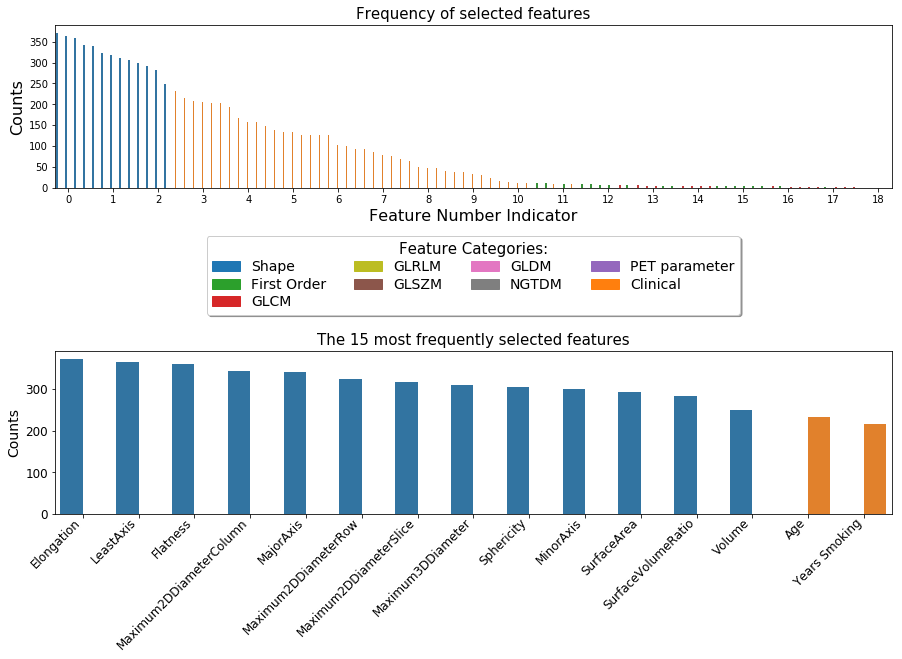

In [10]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 9))
plt.tick_params(axis='both', labelsize=12)
prep_labels = [
    'Shape', 
    'First Order', 
    'GLCM', 
    'GLRLM', 
    'GLSZM', 
    'GLDM', 
    'NGTDM', 
    'PET parameter',
    'Clinical'
]
colours = OrderedDict(
    [
        ('Shape', sns.color_palette()[0]),
        ('Clinical', sns.color_palette()[1]),
        ('First Order', sns.color_palette()[2]),
        ('GLCM', sns.color_palette()[3]),
        ('GLRLM', sns.color_palette()[8]),
        ('GLSZM', sns.color_palette()[5]),
        ('GLDM', sns.color_palette()[6]),
        ('NGTDM', sns.color_palette()[7]),
        ('PET parameter', sns.color_palette()[4])
    ]
)
keys = feature_labels(labels)
handles = [
    mpatches.Patch(color=colours[key], label=key) for key in prep_labels
]
sns.barplot(
    x=np.arange(np.size(sorted_votes)), 
    y=sorted_votes, 
    ax=axes[0], 
    hue=keys,
    palette=colours,
)
feature_id = range(1, sorted_votes.size, 5)
axes[0].set_title('Frequency of selected features', fontsize=15)
axes[0].set_xticks(feature_id)
axes[0].set_ylabel('Counts', fontsize=16)
axes[0].set_xlabel('Feature Number Indicator', fontsize=16)
axes[0].legend(
    handles=handles,
    title='Feature Categories:', 
    title_fontsize=15,
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.25), 
    fancybox=True, 
    shadow=True, 
    fontsize=14,
    ncol=4,
    labelspacing=0.25
)

n = 15
keys = feature_labels(labels[:n])
sns.barplot(
    x=np.arange(np.size(sorted_votes[:n])), 
    y=sorted_votes[:n], 
    ax=axes[1], 
    hue=keys,
    palette=colours,
)
fnames = prep_feature_labels(labels[:n])
axes[1].legend().set_visible(False)
axes[1].set_title('The {} most frequently selected features'.format(n), fontsize=15)
axes[1].set_xticklabels(fnames, rotation=45, ha='right', va='center_baseline')
axes[1].set_ylabel('Counts', fontsize=14)

plt.subplots_adjust(hspace=1)

plt.savefig(
    './../../../figures/biomarkers.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

In [11]:
cats = ['shape',
        'firstorder',
        'glcm',
        'glrlm',
        'glszm',
        'gldm',
        'ngtdm']
res = {}
for cat in cats:
    p = 0
    c = 0
    for label in labels:
        if cat in label:
            c = c + 1
    res[cat] = c
            
res

{'shape': 13,
 'firstorder': 18,
 'glcm': 20,
 'glrlm': 0,
 'glszm': 0,
 'gldm': 0,
 'ngtdm': 0}

In [12]:
# NOTE: Num clinical features.
len(labels) - sum(res.values())

42

In [13]:
len(list(X.filter(regex='shape').columns))

13

In [14]:
len(list(X.filter(regex='CT').columns))

276

In [15]:
len(list(X.filter(regex='PET').columns))

279

In [16]:
nogos = list(X.filter(regex='shape').columns) 
nogos = nogos + list(X.filter(regex='CT').columns) 
nogos = nogos + list(X.filter(regex='PET').columns)

cols = {}
for num, col in enumerate(X.columns):
    if col not in nogos:
        cols[col] = sorted_votes[num]
        print(col, ':', sorted_votes[num])
        
# Pasienten er mann/kvinne er relativt viktig. Det er flere menn enn kvinner
# i datasettet. Kan være knyttet til HPV variabel fordi ikke utypisk at menn får HPV?.

# 

Age : 233
Years Smoking : 215
Naxogin Days : 207
Sex_M : 206
ICD-10_C02 : 204
ICD-10_C03 : 203
ICD-10_C04 : 195
ICD-10_C05 : 167
ICD-10_C06 : 159
ICD-10_C09 : 157
ICD-10_C10 : 149
ICD-10_C12 : 138
ICD-10_C13 : 133
ICD-10_C32 : 133
T Stage_2 : 128
T Stage_3 : 128
T Stage_4 : 127
N Stage_1 : 126
N Stage_2 : 104
N Stage_3 : 101
Histology_1.0 : 94
Histology_2.0 : 93
Histology_3.0 : 86
HPV_1 : 78
HPV_2 : 77
ECOG_1 : 70
ECOG_2 : 65
Charlson_1 : 50
Charlson_2 : 49
Charlson_3 : 48
Charlson_4 : 40
Charlson_5 : 38
Cisplatin_1 : 38
Cisplatin_2 : 33
Cisplatin_3 : 31
Cisplatin_4 : 25
Cisplatin_5 : 18
Cisplatin_6 : 14
Stage 1 : 13
Stage 2 : 13
Stage 3 : 13
Stage 4 : 13


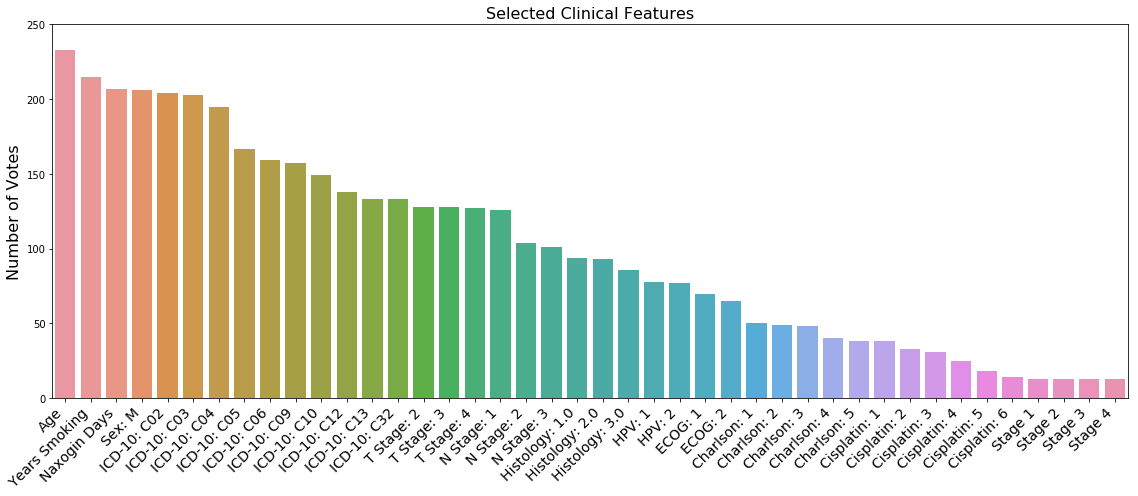

In [17]:
x_coords = np.arange(len(cols.values()))
clinical_labels = prep_feature_labels(cols.keys())

plt.figure(figsize=(16, 7))
plt.title('Selected Clinical Features', fontsize=16)
sns.barplot(x=x_coords, y=list(cols.values()))
plt.xticks(x_coords, clinical_labels, rotation=45, ha='right', fontsize=14)
plt.ylabel('Number of Votes', fontsize=16)
plt.ylim([0, 250])
plt.tight_layout()
plt.savefig(
    './../../../figures/clinical_feature_biomarker.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

In [18]:
# Group by encoded features.
df_clinical = pd.DataFrame.from_dict(cols, orient='index', columns=['Votes'])
df_clinical.head()

,Votes
Age,233
Years Smoking,215
Naxogin Days,207
Sex_M,206
ICD-10_C02,204


In [19]:
grouper = []
for num, label in enumerate(df_clinical.index):
    if 'ICD-10' in label:
        grouper.append('IDC-10')
    elif 'Stage' in label:
        grouper.append('Stage')
    elif 'Histology' in label:
        grouper.append('Histology')
    elif 'HPV' in label:
        grouper.append('HPV')
    elif 'ECOG' in label:
        grouper.append('ECOG')
    elif 'Charlson' in label:
        grouper.append('Charlson')
    elif 'Cisplatin' in label:
        grouper.append('Cisplatin')
    else:
        grouper.append(label)

df_clinical['groups'] = grouper

df_clinical.head()

,Votes,groups
Age,233,Age
Years Smoking,215,Years Smoking
Naxogin Days,207,Naxogin Days
Sex_M,206,Sex_M
ICD-10_C02,204,IDC-10


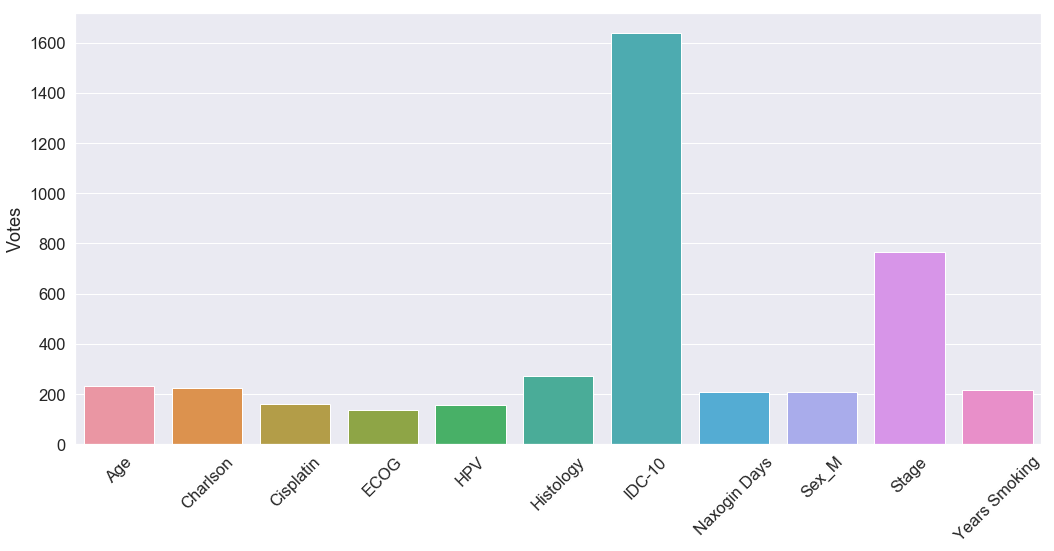

In [20]:
# Missing: 
df_clinical_grps = df_clinical.groupby('groups').sum()

plt.figure(figsize=(15, 8))
sns.set(font_scale=1.5)
sns.barplot(y='Votes', x=df_clinical_grps.index, data=df_clinical_grps)
plt.xlabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(
    './../../../figures/grouped_clinical_feature_biomarker.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

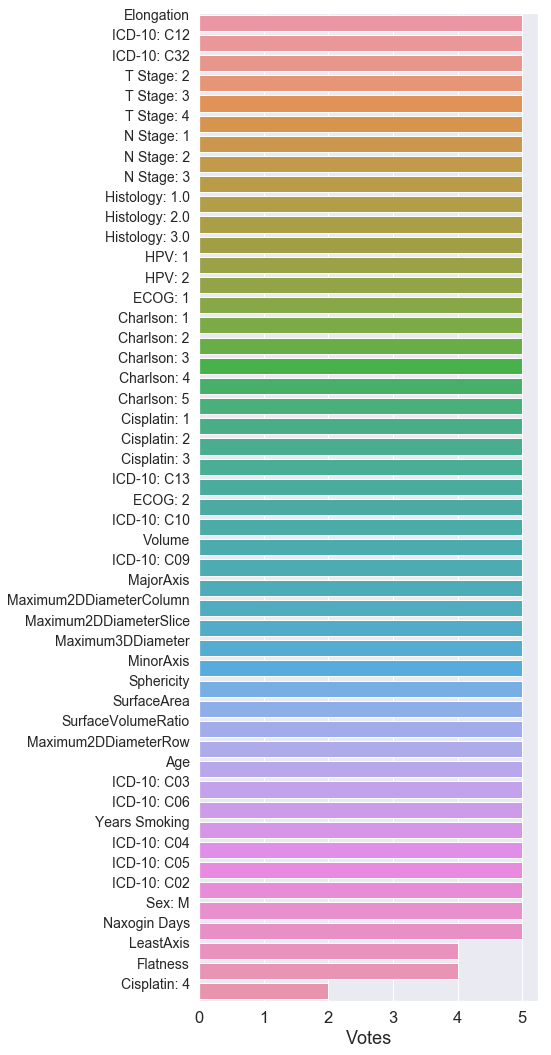

In [21]:
idx = int(np.squeeze(np.where(results['test_score'] == results['test_score'].max())))
best_run = results.iloc[idx, :]
best_run_votes = best_run['feature_votes']
_votes = list(best_run_votes.replace(' ', '').replace('\n', ''))
votes_arr = np.array(list(map(int, list(_votes[1:-1]))), dtype=int)

idx = np.argsort(votes_arr)[::-1]
labels = np.array(features)[idx]
sorted_votes = np.trim_zeros(votes_arr[idx], trim='b')
labels = prep_feature_labels(labels[:len(sorted_votes)])

y_coords = np.arange(np.size(labels))

plt.figure(figsize=(8, 15))
sns.set(font_scale=1.5)
sns.barplot(y=labels, x=sorted_votes, )
plt.xlabel('Votes')
plt.yticks(y_coords, labels, va='bottom', fontsize=14)
plt.tight_layout()

plt.savefig(
    './../../../figures/best_run_features.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

In [22]:
# Group by encoded features.
df_clinical = pd.DataFrame(sorted_votes, columns=['Votes'])
df_clinical.index = labels
df_clinical.head()

,Votes
Elongation,5
ICD-10: C12,5
ICD-10: C32,5
T Stage: 2,5
T Stage: 3,5


In [23]:
grouper = []
for num, label in enumerate(df_clinical.index):
    if 'ICD-10' in label:
        grouper.append('IDC-10')
    elif 'Stage' in label:
        grouper.append('Stage')
    elif 'Histology' in label:
        grouper.append('Histology')
    elif 'HPV' in label:
        grouper.append('HPV')
    elif 'ECOG' in label:
        grouper.append('ECOG')
    elif 'Charlson' in label:
        grouper.append('Charlson')
    elif 'Cisplatin' in label:
        grouper.append('Cisplatin')
    else:
        grouper.append(label)

df_clinical['groups'] = grouper

df_clinical.head()

,Votes,groups
Elongation,5,Elongation
ICD-10: C12,5,IDC-10
ICD-10: C32,5,IDC-10
T Stage: 2,5,Stage
T Stage: 3,5,Stage


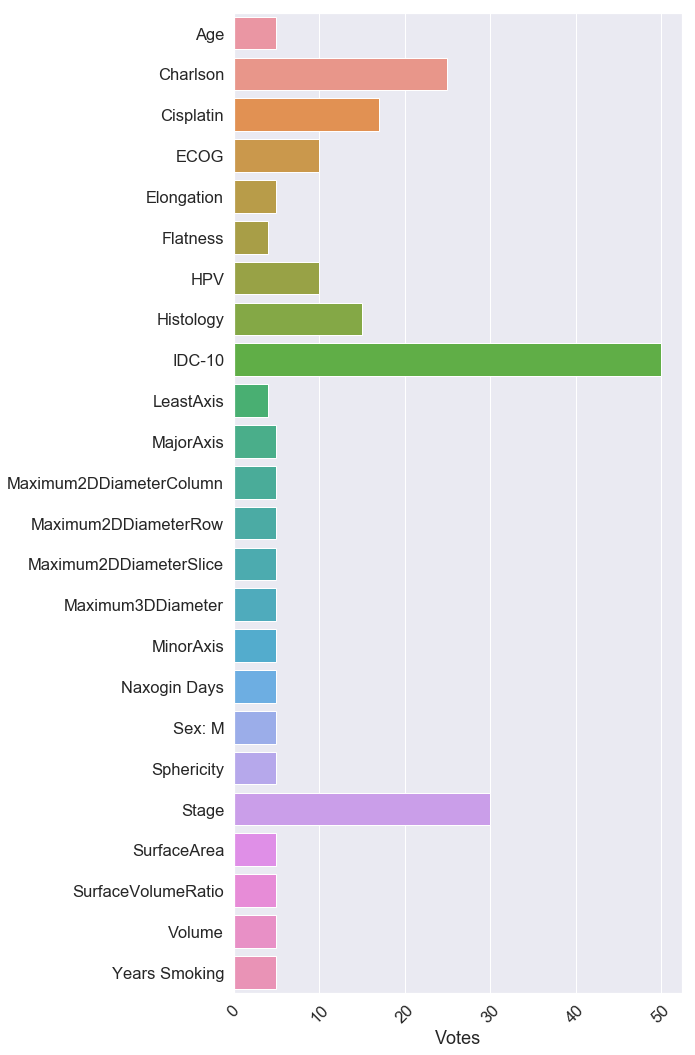

In [27]:
# Missing: 
df_clinical_grps = df_clinical.groupby('groups').sum()

plt.figure(figsize=(10, 15))
sns.set(font_scale=1.5)
sns.barplot(x='Votes', y=df_clinical_grps.index, data=df_clinical_grps)
plt.xlabel('Votes')
plt.ylabel('')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(
    './../../../figures/grouped_best_run_features.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)